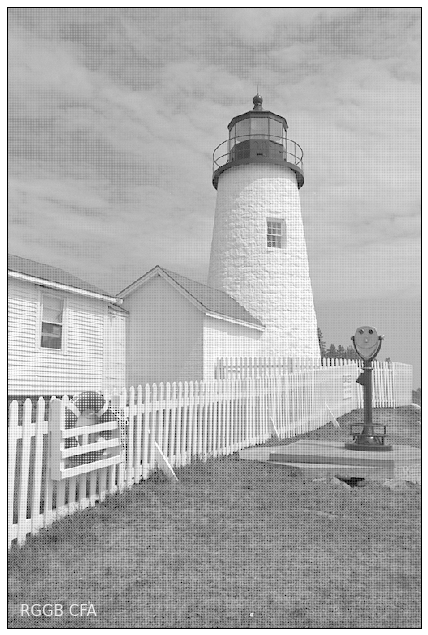

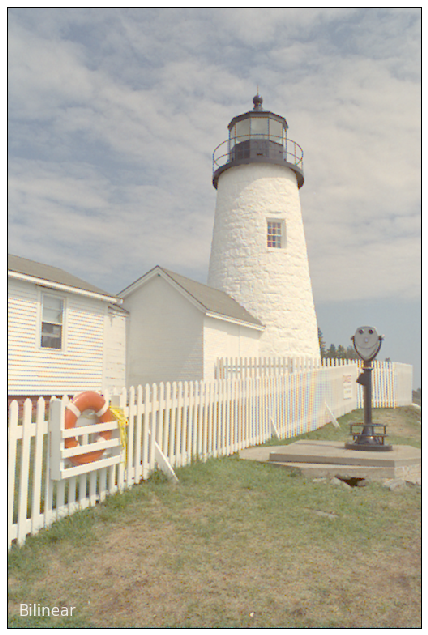

/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/colour/models/dataset/srgb.py:111: RuntimeWarning: invalid value encountered in power
  1.055 * (value ** (1 / 2.4)) - 0.055)


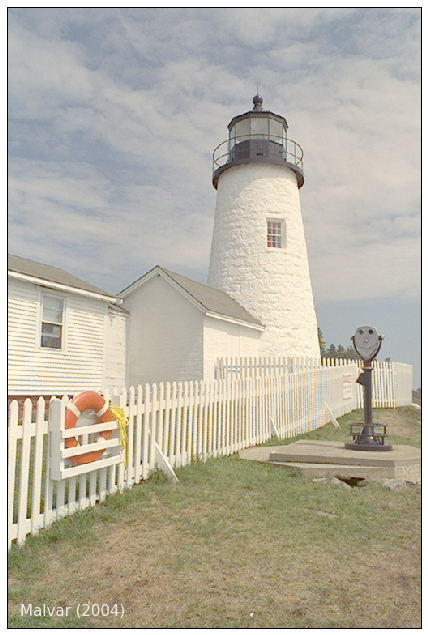

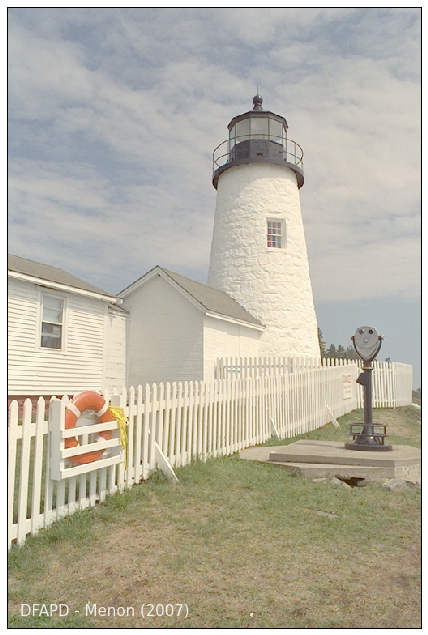

True

In [1]:
%matplotlib inline

from __future__ import division

import numpy as np

import colour
from colour.plotting import *

from colour_demosaicing import (
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_DDFAPD,
    mosaicing_CFA_Bayer)

DIRECTORY = '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/CFA/'

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

IMAGE = np.squeeze(colour.read_image(DIRECTORY + 'lighthouse.tif'))

CFA = mosaicing_CFA_Bayer(IMAGE, 'RGGB')

colour.write_image(colour.tstack((CFA, CFA, CFA)), DIRECTORY + 'lighthouse_CFA.tif')

image_plot(OECF(colour.tstack((CFA, CFA, CFA))), 'RGGB CFA')

image_plot(OECF(demosaicing_CFA_Bayer_bilinear(CFA, 'RGGB')), 'Bilinear')    
image_plot(OECF(demosaicing_CFA_Bayer_Malvar2004(CFA, 'RGGB')), 'Malvar (2004)') 
image_plot(OECF(demosaicing_CFA_Bayer_DDFAPD(CFA, 'RGGB')), 'DFAPD - Menon (2007)') 